In [1]:
from __future__ import division

In [2]:
%load_ext autoreload
%autoreload 1

In [3]:
import math

In [4]:
import numpy as np

In [5]:
import pandas as pd
pd.options.display.max_rows = 999

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [20]:
import tensorflow as tf
import xgboost as xgb

# Discussion

Signal: $H \rightarrow \tau \tau \rightarrow l h$

BackGround:
- $Z \rightarrow \tau \tau \rightarrow lh$
- $t \bar{t} \rightarrow l \tau$
- $W \rightarrow l \tau$


Each event has:
- 1 tau (hadronic)
- 1 lepton (e or mu)
- 0 to 3 jets


The Loss function is given by:
    
$AMS = \sqrt{2 (s + b + b_r) log(1 + \frac{s}{b+b_r})  - s}$

Our function will output 0, 1 labels.  We want to minimize the value of the above for all rows we label as 1 using the TRUE values of s, b.  However, this will create a non-differentiable loss function, which will hurt XGBoost.

Instead, we will write our loss function for fitting based on the above, but using continuous scores instead of hard lables.  To do so, we need to write s and b in terms of continuous scores.

For our truth array, 1 = signal, 0 = background
s = count of signal in selected region 

Therefore, s = sum(truth * predicted)

And we can extend this to the region where predicted is continuous.

Similarly, b = sum( (1-truth) * predicted))


$Loss(\vec{P}, \vec{T})^2 = 2 (b_r + \sum_i P_i*T_i + (1-T_i)*P_i) log(1 + \frac{\sum_i P_i*T_i }{b_r + \sum_i (1-T_i)*P_i})  - \sum_i P_i*T_i$

$Loss(\vec{P}, \vec{T})^2 = 2 (b_r + \sum_i P_i) log(1 + \frac{\sum_i P_i*T_i }{b_r + \sum_i (1-T_i)*P_i})  - \sum_i P_i*T_i$

obj: The Objective function that is minimized

feval: An evaluation function that is calculated on the result (not used in actual fitting).  This may be the same thing as the objective, or may be different

In [7]:
# Open the training data

In [221]:
training.groupby(training.Label).Weight.sum()

Label
b    288208.302825
s       484.054976
Name: Weight, dtype: float64

In [8]:
training = pd.read_csv('../data/training_processed.csv').set_index('EventId')
evaluation = pd.read_csv('../data/evaluation_processed.csv').set_index('EventId')
holdout = pd.read_csv('../data/holdout_processed.csv').set_index('EventId')

In [9]:
feature_cols = [col for col in training if col not in {'Weight', 'Label'}]

In [10]:
print len(training)
print len(holdout)

175000
13500


In [11]:
training.head(8).T

EventId,105136,210343,136895,233964,162483,290117,206962,333210
DER_mass_MMC,102.043,82.885,90.573,106.626,87.075,155.873,150.762,129.911
DER_mass_transverse_met_lep,36.328,44.507,68.7,76.534,18.164,112.795,102.301,35.922
DER_mass_vis,65.23,60.962,65.81,71.003,61.606,107.324,99.311,81.196
DER_pt_h,79.516,16.569,94.79,52.43,78.064,69.656,40.981,59.063
DER_deltaeta_jet_jet,-999,-999,1.935,-999,-999,-999,-999,-999
DER_mass_jet_jet,-999,-999,98.711,-999,-999,-999,-999,-999
DER_prodeta_jet_jet,-999,-999,-0.364,-999,-999,-999,-999,-999
DER_deltar_tau_lep,2.41,3.046,1.695,2.691,1.746,2.45,3.142,2.798
DER_pt_tot,3.329,21.653,37.781,25.432,52.695,8.024,40.981,0.201
DER_sum_pt,154.854,95.661,171.102,109.649,117.838,178.748,100.637,128.659


## Plot the features

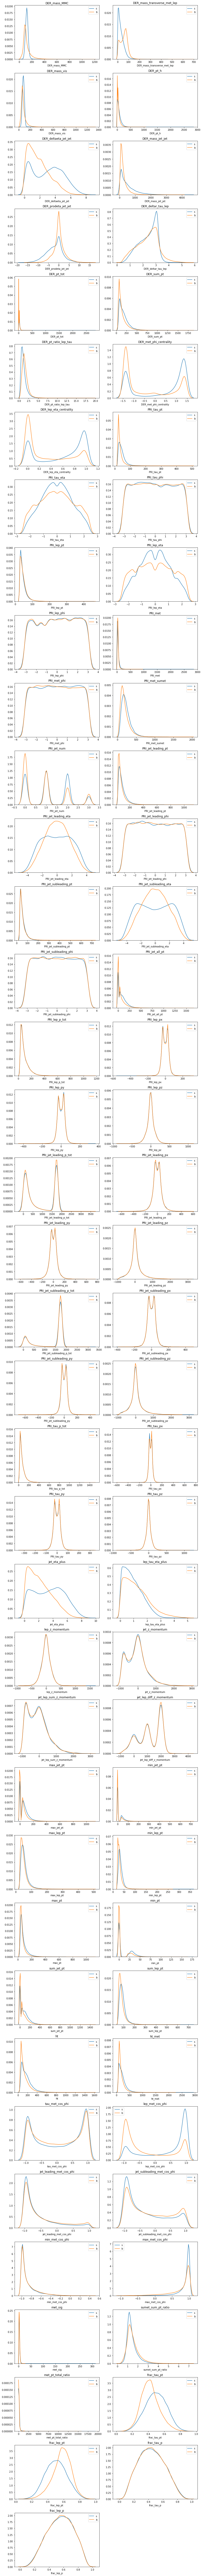

In [12]:
num_features = len(feature_cols)
ncols, nrows = 2, math.ceil(num_features / 2)

fig = plt.figure(figsize=(12, 4*nrows))

labels = training.Label.unique()

for i, f in enumerate(feature_cols):
    
    plt.subplot(nrows, ncols, i+1)
                  
    for label in labels:
        try:
            sns.distplot(training[(training.Label==label) & (training[f] > -900)][f].dropna(), label=label, ax=plt.gca(),
                     hist=False, rug=False)
        except:
            print "UNABLE TO PLOT {}".format(f)
            raise
    plt.title(f)
        
plt.tight_layout()

## Train Models

obj: The Objective function that is minimized

feval: An evaluation function that is calculated on the result (not used in actual fitting). This may be the same thing as the objective, or may be different

In [285]:
features_to_use = ['DER_mass_MMC',
'DER_mass_transverse_met_lep',
'DER_mass_vis',
'DER_pt_h',
'DER_deltaeta_jet_jet',
'DER_mass_jet_jet',
'DER_prodeta_jet_jet',
'DER_deltar_tau_lep',
'DER_sum_pt',
'DER_pt_ratio_lep_tau',
'DER_met_phi_centrality',
'DER_lep_eta_centrality',
'PRI_tau_pt',
'PRI_tau_eta',
'PRI_lep_eta',
'PRI_jet_num',
'PRI_jet_leading_eta',
'PRI_jet_subleading_eta',
'PRI_jet_all_pt',
'jet_eta_plus',
'lep_tau_eta_plus',
'min_pt',
'lep_met_cos_phi',
'jet_subleading_met_cos_phi',
'max_met_cos_phi',
'frac_tau_pt']


In [286]:
def feval_ams(preds, dtrain):
    
   # print preds[:10]
    
    preds = 1.0 / (1.0 + np.exp(-preds))
    labels = dtrain.get_label()
    weights = dtrain.get_weight()
    
    # We use the predicted score to make 0, 1 labels
    pred_label = (preds >= 0.50)
    
    s = (pred_label*labels*weights).sum()
    b = (pred_label*(1.0-labels)*weights).sum()
    br = 10
    
    arg = 2 * (s + b + br) * math.log(1 + (s)/(b + br)) - s
    
    #print "s={} b={} arg={} AMS={}".format(s, b, arg,  math.sqrt(arg))
    
    return 'AMS', math.sqrt(arg)

In [287]:
def obj_ams(preds, dtrain):
    
    # Calculate the gradient and hesse
    # of the ams loss function
    
    labels = dtrain.get_label()
    weights = dtrain.get_weight()
    
    s = (preds*labels*weights).sum()
    b = (preds*(1.0-labels)*weights).sum()
    br = 10
    
    # Vector where the ith member
    # is the derivitiv in terms of the
    # ith prediction
    ds_dp = labels*weights
    db_dp = (1.0-labels)*weights
    
    dloss_ds = 2 * (s + b + br) * (1/(1 + s/(b+br)))*(1/(b+br))       + 2*math.log(1 + s/(b+br)) - 1
    dloss_db = 2 * (s + b + br) * (1/(1 + s/(b+br)))*(-1*s/(b+br)**2) + 2*math.log(1 + s/(b+br))
    
    grad = dloss_ds*ds_dp + dloss_db*db_dp
    hesse = np.zeros(len(preds))
    
    #print len(preds), len(grad), len(hesse)
    
    return grad, hesse
    

In [288]:
def feval_ams_approx(x, dtrain):
    
   # print preds[:10]
    
    preds = 1.0 / (1.0 + np.exp(-x))
    labels = dtrain.get_label()
    weights = dtrain.get_weight()
    
    # We use the predicted score to make 0, 1 labels
    pred_label = (preds >= 0.50)
    
    s = (pred_label*labels*weights).sum()
    b = (pred_label*(1.0-labels)*weights).sum()
    br = 10
    
    print "s={} b={}".format(s, b)
    
    return 'AMS-approx', s / math.sqrt(b + br)

In [289]:
def obj_ams_approx(x, dtrain):
    # Calculate the gradient and hesse
    # of the ams loss function
    
    preds = 1.0 / (1.0 + np.exp(-x))
    labels = dtrain.get_label()
    weights = dtrain.get_weight()
    
    s = (preds*labels*weights).sum()
    b = (preds*(1.0-labels)*weights).sum()
    br = 10.0
    
    # Vector where the ith member
    # is the derivitive in terms of the
    # ith prediction
    ds_dp = labels       * weights * np.exp(-1*x) / (1 + np.exp(-1*x))**2 #(1 / (1 + np.exp(preds)))
    db_dp = (1.0-labels) * weights * np.exp(-1*x) / (1 + np.exp(-1*x))**2

    dloss_ds = (b + br)**(-.5)
    dloss_db = .5 * s * (b + br)**(-1.5)

    grad = dloss_ds*ds_dp + dloss_db*db_dp
    
    #d2loss_ds2 = 0.0
    #d2loss_db2 = .75 * s * (b + br)**(-2.5)
    #hesse = d2loss_ds2 * ds_dp * ds_dp + d2loss_db2 * db_dp * db_dp

    hesse = np.ones(len(x)) * 0.0001
        
    #for l, p, w, g, h in zip(labels[:10], preds[:10], weights[:10], grad[:10], hesse[:10]):
    #    print "{:.3f} {} {:.5f} {:.8f} {:.8f}".format(w, l, p, g, h) #print l, p, w, g, h
    
    return grad, hesse
    

    #return grad, hesse
    #return 2 * (preds - labels) * weights, 2 * np.ones(len(preds)) * weights
    
    #return 2*labels - 1, np.zeros(len(preds))
    

In [290]:
def obj_ams_simple(x, dtrain):
    # Calculate the gradient and hesse
    # of the ams loss function
    
    preds = 1.0 / (1.0 + np.exp(-x))
    labels = dtrain.get_label()
    weights = dtrain.get_weight()
    
    s = (preds*labels*weights).sum()
    b = (preds*(1.0-labels)*weights).sum()
    br = 10.0
    
    # Vector where the ith member
    # is the derivitive in terms of the
    # ith prediction
    ds_dx = labels       * weights * preds * (1.0 - preds)
    db_dx = (1.0-labels) * weights * preds * (1.0 - preds)

    d2s_dx2 = labels       * weights * (2*preds**3 - 3*preds**2 + preds)
    d2b_dx2 = (1.0-labels) * weights * (2*preds**3 - 3*preds**2 + preds)
    
    dloss_ds = 1/s
    d2loss_ds2 = -1/s/s

    dloss_db = -.5/(b+br)
    d2loss_db2 = .5/(b+br)/(b+br)
    
    grad = dloss_ds*ds_dx + dloss_db * db_dx
    
    hesse = d2loss_ds2*(ds_dx)**2 + dloss_ds*d2s_dx2 + d2loss_db2*(db_dx)**2 + dloss_db*d2b_dx2
   
    for l, p, w, g, h in zip(labels[:10], preds[:10], weights[:10], grad[:10], hesse[:10]):
        print "{:.3f} {} {:.5f} {:.8f} {:.8f}".format(w, l, p, g, h) #print l, p, w, g, h
    
    return grad, hesse


In [324]:
class XGBoostModel(object):
    
    def __init__(self, feature_names, df_evaluation=None):
        self._feature_names = list(feature_names)
        self._df_evaluation = df_evaluation
        
        # Define the loss graph
        graph = tf.Graph()

        with graph.as_default():
    
            preds = tf.placeholder(tf.float64, [None, 1])
            labels = tf.placeholder(tf.float64, [None, 1])
            weights = tf.placeholder(tf.float64, [None, 1])
    
            probs = tf.sigmoid(preds)
    
            s = tf.reduce_sum(labels*probs*weights) # * weights
            b = tf.reduce_sum((1.0-labels)*probs*weights) # * weights
            br = 10.0
    
            #loss_a = -1*((s + b + br) * tf.log(1.0 + s / (b + br)) - s)            
            #loss_b = tf.reduce_sum(1000 * labels * (probs-labels)**2 + 0.01 *(1-labels)*(probs-labels)**2) / tf.reduce_sum(weights)
            #loss = loss_a + loss_b
            
            loss_a = -1 * tf.log(s) + 0.5*tf.log(b + br)
            #loss_a = -1*s / tf.sqrt(b+br)
            loss_b = -1*tf.reduce_mean((probs-0.5)*(probs-0.5))  # / tf.reduce_sum(weights)
            loss = loss_a + loss_b
            
            grad = tf.gradients(loss, preds)
            hesse = tf.gradients(grad, preds)
            
        self._preds = preds
        self._labels = labels
        self._weights = weights
        
        self._graph = graph
        
        self._s = s
        self._b = b
        
        self._loss = loss
        self._loss_a = loss_a
        self._loss_b = loss_b
        self._grad = grad
        self._hesse = hesse
        
    def grad_hesse(self, preds, dtrain):
        
        labels = dtrain.get_label()
        weights = dtrain.get_weight()
                
        sess = tf.Session(graph=self._graph)
        
        with sess as s:
            loss, s, b, loss_a, loss_b, grad, hesse = sess.run([self._loss, self._s, self._b, self._loss_a, self._loss_b,
                                                          self._grad, self._hesse],
                                   feed_dict={
                                       self._preds: preds.reshape((len(preds)), 1),
                                       self._labels: labels.reshape((len(labels), 1)),
                                       self._weights: weights.reshape((len(weights), 1))
                                   })
        #print preds[:10]
        #print "Loss: {} ({}, {}) (s={} b={})".format(loss, loss_a, loss_b, s, b)
        #print grad[0]
        return grad[0], hesse[0]

            
    def make_dmatrix(self, X, y, weight):
        label = y.map(lambda x: 1.0 if x == 's' else 0.0)        
        return xgb.DMatrix(X[self._feature_names],
                           label=label,
                           weight=weight,
                           feature_names=self._feature_names)
        
        
    def fit(self, X, y, weight):
                
        param = {'max_depth': 2,
                 'eta': .5,
                 'silent': 1,
                 #'objective': 'binary:logistic',
                 'eval_metric': 'auc',
                 'gamma': 0.0,
                 'min_child_weight': 0,
                 'lambda': 0.0,
                 'scale_pos_weight': 1
                 }
        
        param['nthread'] = 4
        
        dtrain = self.make_dmatrix(X, y, weight)
        evallist = [(dtrain, 'train')]
        
        if self._df_evaluation is not None:

            matrix = self.make_dmatrix(
                self._df_evaluation,
                self._df_evaluation.Label,
                self._df_evaluation.Weight)
            
            evallist.append((matrix, 'eval'))
        
        num_round = 20
        
        # early_stopping_rounds=15, 
        bst = xgb.train(param.items(), dtrain, num_round, evallist,
                        feval=feval_ams,
                        obj=lambda x, T: self.grad_hesse(x, T),  
                        verbose_eval=True)
        
        self._fitted = bst
    
    def predict_raw(self, ds):
        dset = self.make_dmatrix(ds,
                ds.Label,
                ds.Weight)
        return pd.Series(self._fitted.predict(dset))
    

    def predict_proba(self, ds):
        raws = self.predict_raw(ds)
        return pd.Series(1 / (1.0 + np.exp(-1*raws)))
        

In [325]:
boosted_trees = XGBoostModel(features_to_use, evaluation)
boosted_trees.fit(training, training['Label'], training['Weight'])

[0]	train-auc:0.5	eval-auc:0.5	train-AMS:22.0197	eval-AMS:4.66061
[1]	train-auc:0.5	eval-auc:0.5	train-AMS:22.0197	eval-AMS:4.66061
[2]	train-auc:0.5	eval-auc:0.5	train-AMS:22.0197	eval-AMS:4.66061
[3]	train-auc:0.347051	eval-auc:0.347107	train-AMS:22.0197	eval-AMS:4.66061
[4]	train-auc:0.290656	eval-auc:0.286328	train-AMS:22.0197	eval-AMS:4.66061
[5]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[6]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[7]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[8]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[9]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[10]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[11]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[12]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.0197	eval-AMS:4.66061
[13]	train-auc:0.280848	eval-auc:0.2776	train-AMS:22.01

count    1.350000e+04
mean     9.999902e-01
std      8.213066e-07
min      9.999896e-01
25%      9.999896e-01
50%      9.999899e-01
75%      9.999911e-01
max      9.999918e-01
dtype: float64

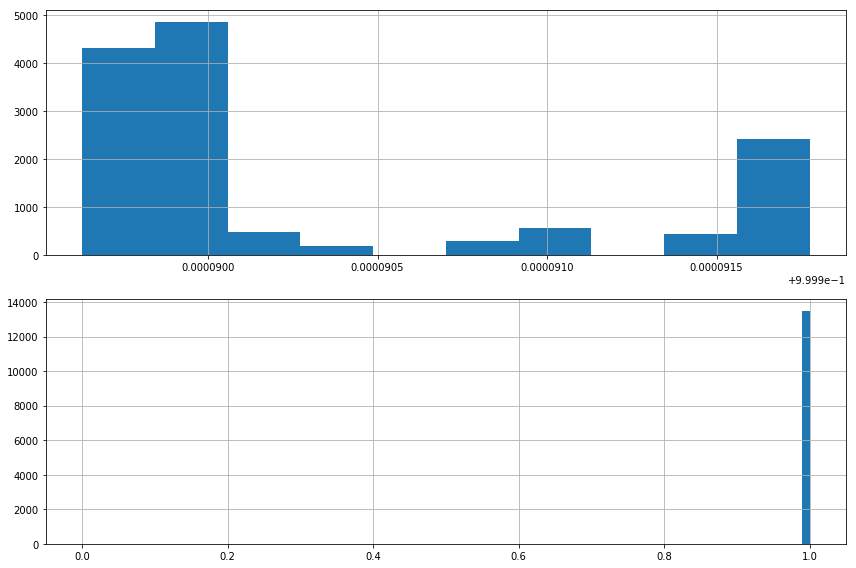

In [333]:
y_hat_holdout = boosted_trees.predict_proba(holdout)

fig = plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
y_hat_holdout.hist()

plt.subplot(2, 1, 2)
y_hat_holdout.hist(bins=np.arange(0.0, 1.01, 0.01))
plt.tight_layout()

y_hat_holdout.describe()

In [ ]:
import numpy as np

sess = tf.Session(graph=graph)
with sess as s:
    
    vals = sess.run([ams_2, grad, hesse],
                   feed_dict={xs: np.array([1, 2, 3, 4, 5]).reshape((5, 1)),
                              T: np.array([1, 0, 1, 1, 1]).reshape((5, 1))})
    
    for val in vals:
        print val
        print ''